In [59]:
! pip install azure.cognitiveservices.vision.face
! pip install msrest

In [60]:
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
import requests
import json
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import sys, os
import environ

env = environ.Env()
environ.Env.read_env()

FACE_API_KEY = env("FACE_API_KEY")
FACE_API_ENDPOINT = env("FACE_API_ENDPOINT")


class TooManyFacesException(Exception):
    def __init__(self):
        self.message = "Too many faces exception"
        super().__init__(self.message)


class NoFaceException(Exception):
    def __init__(self):
        self.message = "No face exception"
        super().__init__(self.message)


class ServerNotRespondingException(Exception):
    def __init__(self):
        self.message = "Problem with Azure's endpoint"
        super().__init__(self.message)


class BlurredFaceException(Exception):
    def __init__(self):
        self.message = "Face in the photo is blurred"
        super().__init__(self.message)


class WrongHeadPositonException(Exception):
    def __init__(self):
        self.message = "Head is rotated in the photo. Add frontal face picture"
        super().__init__(self.message)

In [67]:
class FaceDetector:
    def __init__(self):
        self.face_client = FaceClient(
            FACE_API_ENDPOINT, CognitiveServicesCredentials(FACE_API_KEY))

    def detect_face(self, image_path):
        image = open(image_path, "rb")
        try:
            response = self.send_request_to_azure(image)
        except KeyError as e:
            raise ServerNotRespondingException
        else:
            response_json = response.json()
            if len(response_json) > 1:
                raise TooManyFacesException
            if len(response_json) == 0:
                raise NoFaceException
            if self.check_if_face_blurred(response_json):
                raise BlurredFaceException
            if not self.check_if_face_frontal(response_json):
                raise WrongHeadPositonException
            return self.crop_photo(
                cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB),
                response_json[0]['faceRectangle'])

    def send_request_to_azure(self, image):
        headers = {
            'Content-Type': 'application/octet-stream',
            'Ocp-Apim-Subscription-Key': FACE_API_KEY,
        }
        params = {
            'returnFaceId': 'false',
            'returnFaceLandmarks': 'false',
            'returnFaceAttributes': 'headPose,blur'
        }
        return requests.post(FACE_API_ENDPOINT,
                             params=params,
                             headers=headers,
                             data=image.read())

    def crop_photo(self, image, coords):
        (x, y, w, h) = (coords['left'], coords['top'], coords['width'],
                        coords['height'])
        crop_image = image[y:y + h, x:x + w]
        return crop_image

    def check_if_face_frontal(self, response_json):
        roll = int(response_json[0]['faceAttributes']['headPose']['roll'])
        if abs(roll) > 2.5:
            return False
        return True

    def check_if_face_blurred(self, response_json):
        blur = str(response_json[0]['faceAttributes']['blur']['blurLevel'])
        if (blur == "high"):
            return True
        return False

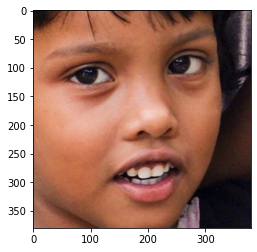

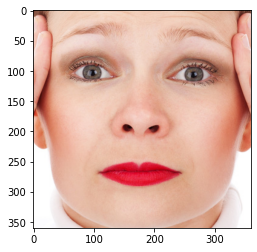

Head is rotated in the photo. Add frontal face picture
Head is rotated in the photo. Add frontal face picture
Head is rotated in the photo. Add frontal face picture


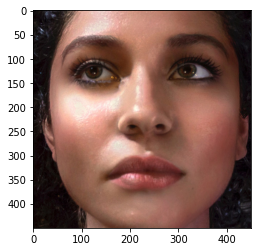

Head is rotated in the photo. Add frontal face picture
Head is rotated in the photo. Add frontal face picture
Head is rotated in the photo. Add frontal face picture


In [68]:
test_detector = FaceDetector()

images_root_path = "/content/drive/MyDrive/faces detection/training_real"
names = ["real_0000" + str(i) + ".jpg" for i in range(1, 10)]
#names2= ["real_000"+str(i)+".jpg" for i in range(10,100)]
test_names = names  #+ names2


def show_face(image_path, coords):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    (x, y, w, h) = (coords['left'], coords['top'], coords['width'],
                    coords['height'])
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 5)
    plt.imshow(image)
    plt.show()


for image_name in test_names:
    image_path = images_root_path + "/" + image_name
    try:
        res = test_detector.detect_face(image_path)
        time.sleep(3)
        plt.imshow(res)
        plt.show()
    except Exception as e:
        print(e)